In [1]:
import os
import shutil
import jsonlines
import numpy as np
import pandas as pd
import pickle as pk
from collections import defaultdict

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.family'] = 'DeJavu Serif'

### Analysis

In [2]:
def load(aspect, score):
    train2style2scores = defaultdict(dict)
    with jsonlines.open(f'Data/{aspect}/_scoreboard_.jsonl') as reader:
        for line in reader:
            ver, ckpt = line['version'], line['ckpt']
            if ver == 'base' and ckpt == 0:
                base = {style:line[f'{style} {score}'] for style in styles}
                continue
            for style in styles:
                if style not in train2style2scores[ver]: 
                    train2style2scores[ver][style] = np.zeros(num_ckpt+1)
                train2style2scores[ver][style][ckpt] = line[f'{style} {score}']
    for train, style2scores in train2style2scores.items():
        for style, scores in style2scores.items():
            scores[0] = base[style]
    return train2style2scores

num_ckpt, num_epoch = 5, 2
styles = ['simplified', 'original', 'list_prefix', 'list_suffix', 'poem_prefix', 'poem_suffix']
train2style2asrs, train2style2wrs = load('Safety', 'asr'), load('Utility', 'lc_wr')

train2scores = {}
trains = list(train2style2asrs.keys())
epochs = np.arange(num_ckpt+1) / num_ckpt * num_epoch
capitalize = lambda x: "_".join([s.capitalize() for s in x.split("_")])
for train in trains:
    style2asrs = {f'{capitalize(style)} ASR':asrs for style, asrs in train2style2asrs[train].items()}
    style2wrs = {f'{capitalize(style)} LC_WR':wrs for style, wrs in train2style2wrs[train].items()}
    train2scores[capitalize(train)] = pd.DataFrame({'Epoch':epochs} | style2asrs | style2wrs)

In [19]:
def rename(ori_style):
    if ori_style == 'Original': return 'Diverse'
    if ori_style == 'Simplified': return 'Removed'
    return ori_style

ratios = [0, 500, 1000]
trains = ['List_Prefix', 'List_Suffix', 'Poem_Prefix', 'Poem_Suffix', 'Original']
styles = ['List_Prefix', 'List_Suffix', 'Poem_Prefix', 'Poem_Suffix', 'Original', 'Simplified']
labels = ['Training Style Data : Style-Removed Data = 0% : 100%', 
          'Training Style Data : Style-Removed Data = 50% : 50%',
          'Training Style Data : Style-Removed Data = 100% : 0%']

num_ckpt, num_epoch = 5, 2
epochs = np.arange(num_ckpt+1) / num_ckpt * num_epoch
fontsize = 9
colors = sns.color_palette("tab10")[:len(labels)][::-1]
num_row, num_col = 5, 6
size_row, size_col = 1.25, 2
ylims = {'ASR':{'bottom':0, 'top':1}, 'LC_WR':{'bottom':10, 'top':50}}

def draw(metric):
    
    fig, axs = plt.subplots(num_row, num_col, figsize=(num_col*size_col, num_row*size_row), 
                            sharex=True, sharey=True)
    for tid, train in enumerate(trains):
        for sid, style in enumerate(styles):

            ax = axs[tid][sid]
            sns.despine(ax=ax, offset=dict(left=2, bottom=2))
            ax.set_ylim(**ylims[metric])
            ax.set_yticks(np.linspace(ylims[metric]['bottom'], ylims[metric]['top'], 5))
            ax.set_xticks(range(num_ckpt+1))
            ax.set_xticklabels(epochs)
            ax.tick_params(axis='both', which='major', labelsize=fontsize-1)

            if sid==0: ax.set_ylabel(metric, fontsize=fontsize+0.5)
            if tid==len(trains)-1: ax.set_xlabel('Epoch', fontsize=fontsize)
            if tid==0: ax.set_title(f'Testing Style:\n{rename(style)}', fontsize=fontsize+1)
            if sid==0: ax.annotate(f'Training Style:\n{rename(train)}', fontsize=fontsize+1,
                                   xy=(0,0.5), xytext=(-ax.yaxis.labelpad-40,0), xycoords=ax.yaxis.label,
                                   textcoords='offset points', ha='center', va='center')

            for lid, label in enumerate([f'{train}-0', f'{train}-500', f'{train}-1000']):
                train_specific = label if lid else 'Simplified-1000'
                ax.plot(train2scores[train_specific][f'{style} {metric}'], label=label, 
                        color=colors[lid], marker='.', lw=1.5)
                
    handles, _ = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=fontsize, ncol=len(labels), columnspacing=1, handletextpad=0.5, 
               bbox_to_anchor=(0.5,0), loc='upper center', bbox_transform=fig.transFigure)
    
    x_sep = 0.848 if metric=='ASR' else 0.8475
    sep_line = mlines.Line2D([x_sep, x_sep], [0.025, 0.975], transform=fig.transFigure, 
                             color="black", linestyle="--", linewidth=1)
    fig.add_artist(sep_line)
    
    plt.tight_layout()
    plt.savefig(f'Figure/train_{metric}.pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)

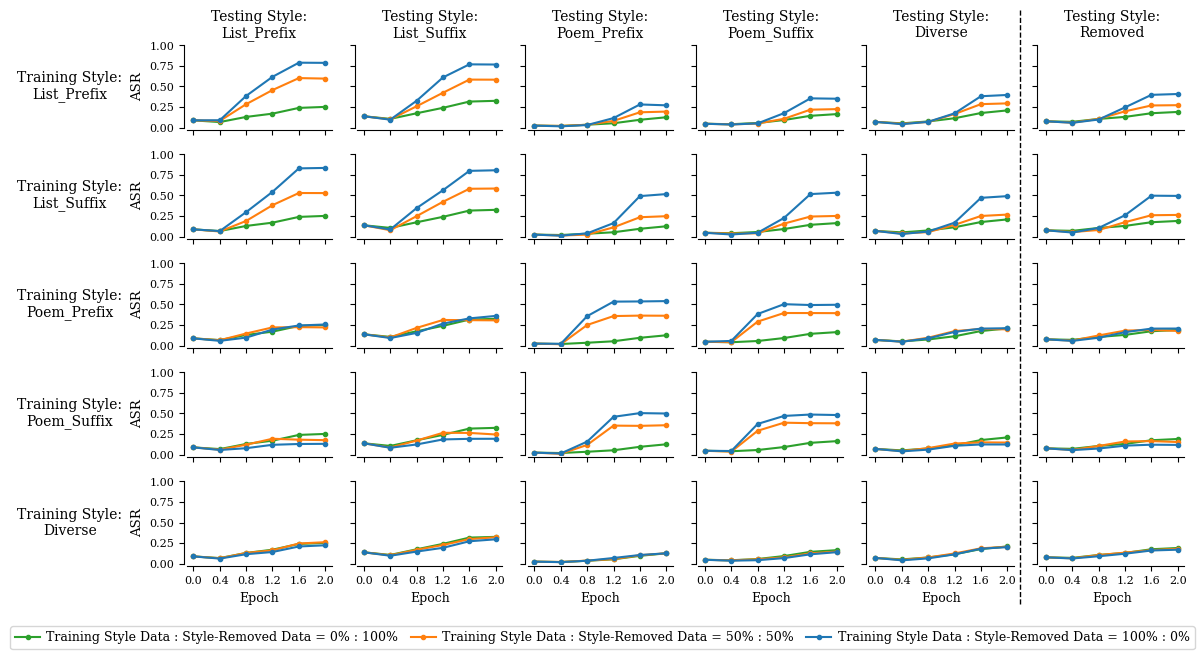

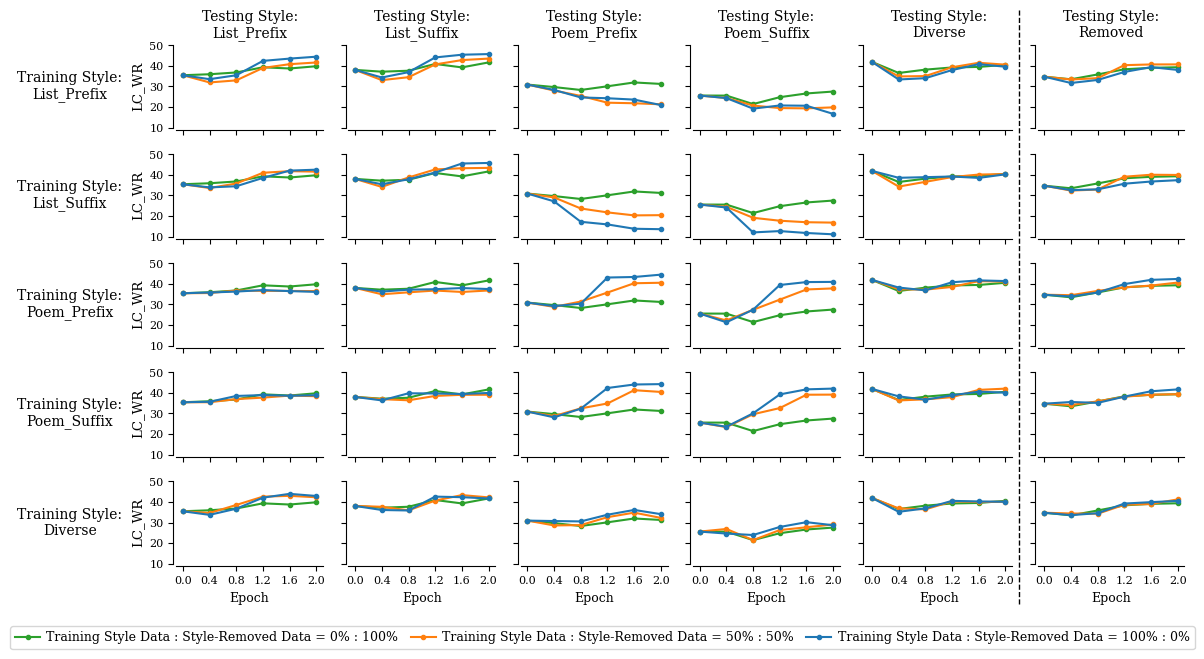

In [20]:
metrics = ['ASR', 'LC_WR']
for metric in metrics:
    draw(metric)